In [41]:
### Library Imports

import pandas as pd
import numpy as np
import math 
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf 
from datetime import timedelta
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from numpy import log 
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
### Import the Stock Info

ticker = 'GOOG'
start_date = '2018-1-1'

data = yf.Ticker(ticker)
# Fetch historical data starting from the specified start_date
history = data.history(start = start_date)
df = pd.DataFrame(history)
# Reset index to make headings in the same row
df.reset_index(inplace = True)
# Convert the date column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])
# Extract only the date part
df['Date'] = df['Date'].dt.date
# Drop 'Dividends' and 'Stock Splits' columns
#df.drop(['Dividends', 'Stock Splits'], axis = 1)

#date = df['Date']

df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02,52.417000,53.347000,52.261501,53.250000,24752000,0.0,0.0
1,2018-01-03,53.215500,54.314499,53.160500,54.124001,28604000,0.0,0.0
2,2018-01-04,54.400002,54.678501,54.200100,54.320000,20092000,0.0,0.0
3,2018-01-05,54.700001,55.212502,54.599998,55.111500,25582000,0.0,0.0
4,2018-01-08,55.111500,55.563499,55.081001,55.347000,20952000,0.0,0.0


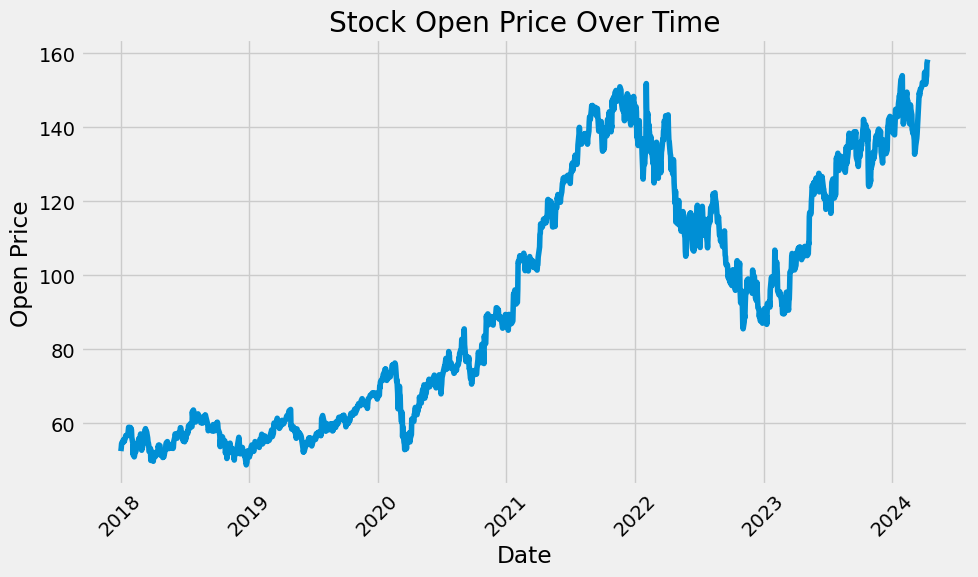

In [39]:
### Plot Data
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Open Price Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
### Perform Dickey-Fuller Test
'''
The ADF (Augmented Dickey-Fuller) test will allow us to determine the presence of unit root in the series, 
and help to understand if the series is stationary or not.

If the p-value < 0.05 (significance level), we reject the null hypothesis and infer the series is stationary
'''
def adf_test(df_column):
    result = adfuller(df_column.dropna())

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Number of Lags Used:', result[2])
    print('Number of Observations Used:', result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    print('Maximized Information Criterion (AIC):', result[5])

    p_val = result[1]
    if p_val < 0.05:
        print(f'Since the p value of: {round(p_val, 4)} < 0.05, we reject the null hypothesis and conclude the data is stationary')
    else:
        print(f'Since the p value of: {round(p_val, 4)} > 0.05, we fail to reject the null hypothesis and conclude the data is non-stationary')

# Assuming 'df' is your DataFrame
df_close = df['Close']
adf_test(df_close)

ADF Statistic: -0.28050507514455914
p-value: 0.9282203746212039
Number of Lags Used: 9
Number of Observations Used: 1569
Critical Values:
   1%: -3.434524653155409
   5%: -2.863383859017768
   10%: -2.567751638185023
Maximized Information Criterion (AIC): 6393.513276282636
Since the p value of: 0.9282 > 0.05, we fail to reject the null hypothesis and conclude the data is non-stationary


In [ ]:
### Convert Non-Stationary Data to Stationary Data


In [54]:
### Autoregression Model

# Log Transformation
df_log = np.log(df['Close'])

# Split data into train and test sets
n = len(df_log)
n_train = int(0.8 * n)
train_data, test_data = df_log[:n_train], df_log[n_train:]

# Build ARIMA Model
ARIMA_model = ARIMA(train_data, order=(9, 1, 0))  # ARIMA(p, d, q) order
fitted = ARIMA_model.fit()

# Make predictions
predictions = fitted.forecast(steps=len(test_data))

# Reverse log transformation for actual and predicted values
actual_prices = np.exp(test_data)
predicted_prices = np.exp(predictions)

# Create a DataFrame with actual, predicted, and date columns
date_range = pd.date_range(start=df['Date'].iloc[n_train], periods=len(test_data), freq='B')  # Assuming 'Date' is in proper datetime format
prediction_df = pd.DataFrame({'Date': date_range, 'Actual': actual_prices.values, 'Predicted': predicted_prices.values})
print(prediction_df)


          Date      Actual  Predicted
0   2023-01-09   88.800003  88.078834
1   2023-01-10   89.239998  88.179680
2   2023-01-11   92.260002  87.805987
3   2023-01-12   91.910004  88.168286
4   2023-01-13   92.800003  88.141193
..         ...         ...        ...
311 2024-03-19  153.940002  88.080257
312 2024-03-20  156.139999  88.080257
313 2024-03-21  158.139999  88.080257
314 2024-03-22  157.660004  88.080257
315 2024-03-25  160.789993  88.080257

[316 rows x 3 columns]


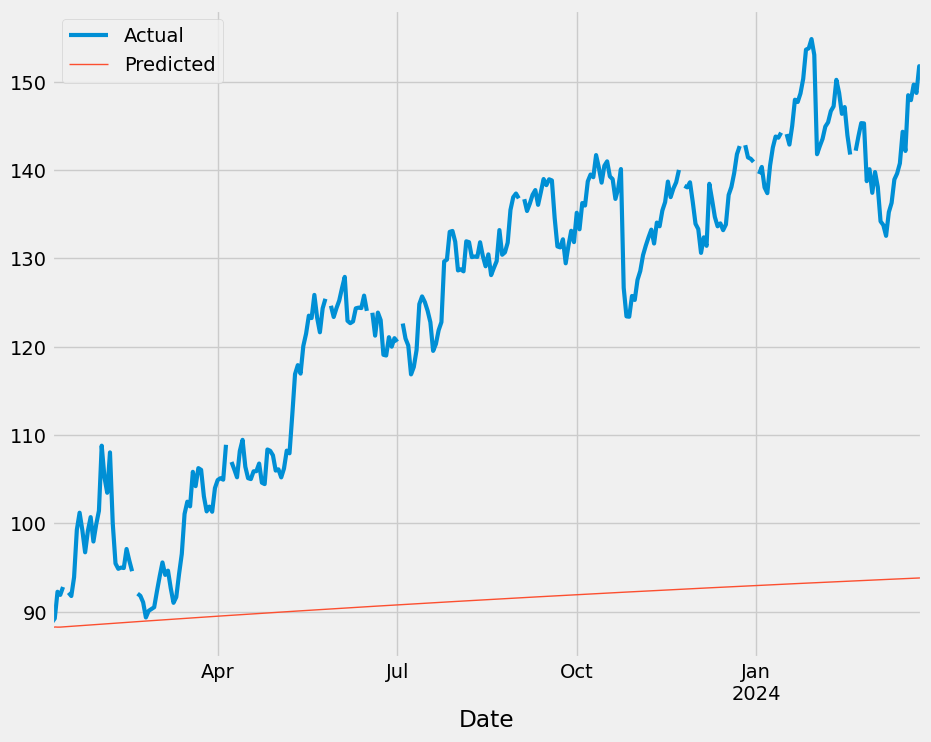

In [8]:
### Plotting Function

# Plot both actual and predicted data on the same graph
ax = result_df.plot(x = 'Date', y = 'Actual', figsize = (10, 8), linewidth = 3)
result_df.plot(x = 'Date', y = 'Predicted', ax = ax, linewidth = 1)
plt.show()

In [11]:
### Splitting Data to Training Set

# Assuming x is a DataFrame containing independent variables, and y is a Series containing the dependent variable
x = df[['Open','High','Low','Volume']]
y = df['Close']   

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.20, shuffle = False, random_state = 0)

# Check if total observations is appropriate
print(train_x.shape) 
print(train_y.shape)
# 20% of total observations
print(test_x.shape) 
print(test_y.shape)


(1263, 4)
(1263,)
(316, 4)
(316,)


In [22]:
### Regression Coefficient and Intercept Calculation

# Create an AutoReg model
model = AutoReg(train_df['Close'], lags=5)

# Fit the model
model_fit = model.fit()

# Display the coefficients and intercept
print("Regression Coefficients:", model_fit.params.values)
print("Regression Intercept:", model_fit.params[0])  # Intercept is usually the first parameter


Regression Coefficients: [ 0.18636533  0.9339126   0.05705138 -0.04344849  0.03316492  0.0175009 ]
Regression Intercept: 0.18636532887491286


In [23]:
# Make predictions on the test data
predictions = model_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)

# Create a DataFrame to store predictions
prediction_df = pd.DataFrame({'Date': test_df.index, 'Actual': test_df['Close'], 'Predicted': predictions})
prediction_df


,Date,Actual,Predicted
1263,1263,88.800003,88.143884
1264,1264,89.239998,88.276564
1265,1265,92.260002,88.257497
1266,1266,91.910004,88.260107
1267,1267,92.800003,88.279484
...,...,...,...
1574,1574,153.940002,93.779838
1575,1575,156.139999,93.793704
1576,1576,158.139999,93.807548
1577,1577,157.660004,93.821369
